# PREDICCIÓN DEL PRECIOS DE ACTIVOS FINANCIEROS EMPLEANDO APRENDIZAJE AUTOMÁTICO
#### Autor: Samuel Valer Nasta

# Librerías empleadas

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns   
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Obtención y análisis de datos

In [2]:
fecha_inicio = '2000-01-01'
fecha_fin = '2023-05-01'

datos_tesla = yf.download('TSLA', start=fecha_inicio, end=fecha_fin)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio, end=fecha_fin)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio, end=fecha_fin)
datos_petroleo = yf.download('CL=F', start=fecha_inicio, end=fecha_fin)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Preprocesamiento de datos

In [3]:
datos_sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


Comprobamos si hay datos nulos o na.

In [4]:
print(datos_tesla.isnull().sum())
print(datos_tesla.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [5]:
print(datos_sp500.isnull().sum())
print(datos_sp500.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [6]:
print(datos_bitcoin.isnull().sum())
print(datos_bitcoin.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [7]:
print(datos_petroleo.isnull().sum())
print(datos_petroleo.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


## Análisis exploratiorio

### Gráfico de lineas

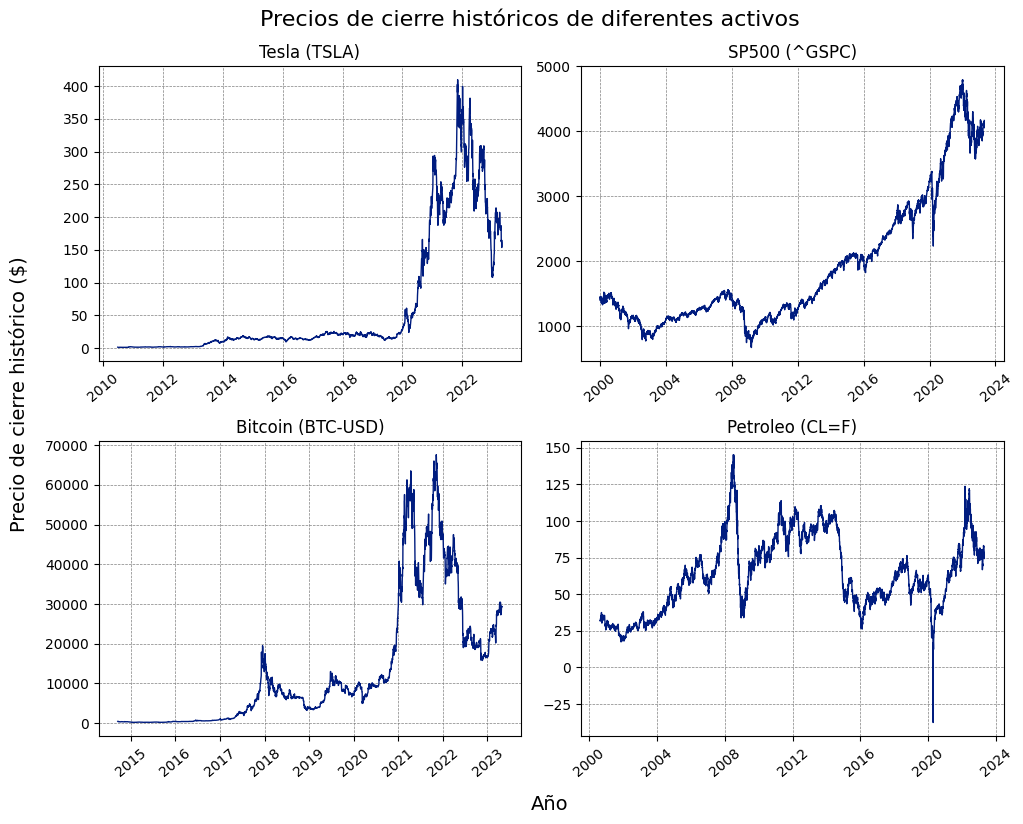

In [8]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(datos_tesla['Adj Close'], linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(datos_sp500['Adj Close'], linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(datos_bitcoin['Adj Close'], linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(datos_petroleo['Adj Close'], linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio de cierre histórico ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Precios de cierre históricos de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()


Aqui vemos como en 2020 hubo un problema por lo que lo vamos a prescindir de estos datos.

### Gráfico de lineas de todas las variables de cada activo en una temporalidad menor

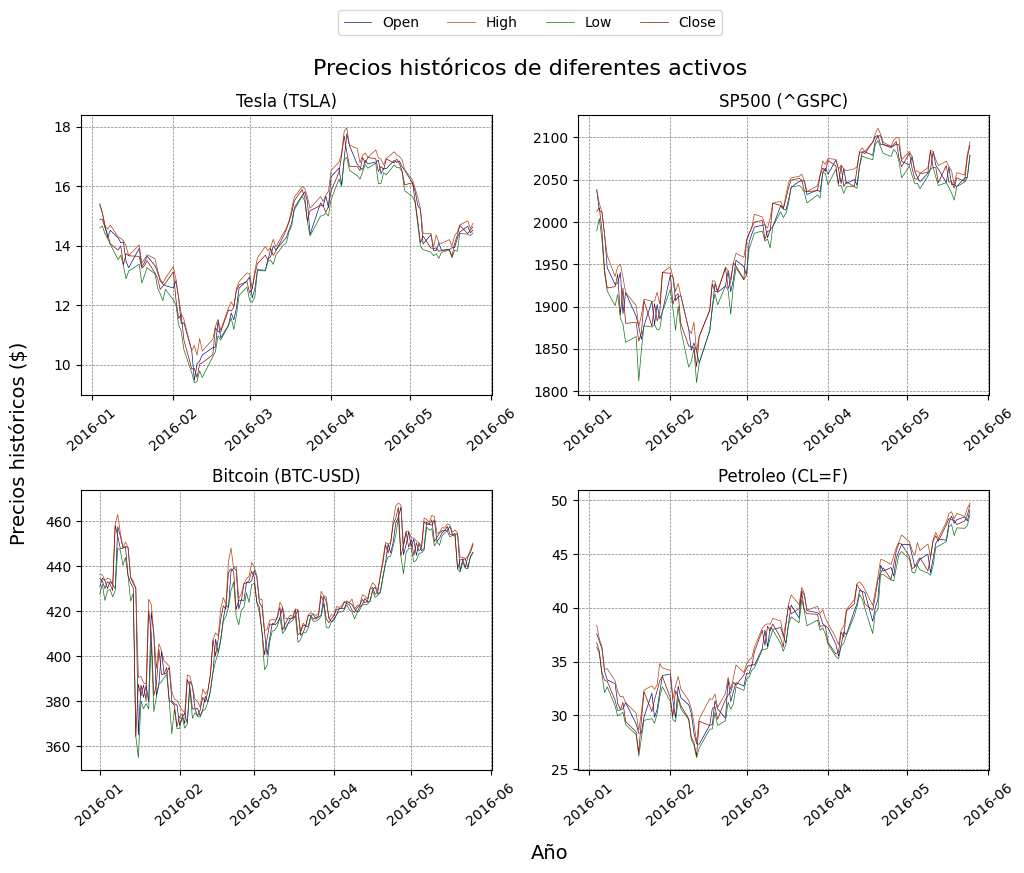

In [9]:
sns.set_palette('dark')

fecha_inicio_plot = '2016-01-01'
fecha_fin_plot = '2016-05-25'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axs = axs.flatten()

datos = [datos_tesla, datos_sp500, datos_bitcoin, datos_petroleo]
titulos = ['Tesla (TSLA)', 'SP500 (^GSPC)', 'Bitcoin (BTC-USD)', 'Petroleo (CL=F)']
etiquetas = ['Open', 'High', 'Low', 'Close']  # etiquetas para la leyenda

for i, ax in enumerate(axs):
    ax.set_title(titulos[i])
    for j, etiqueta in enumerate(etiquetas):
        ax.plot(datos[i].loc[fecha_inicio_plot:fecha_fin_plot, etiqueta], linewidth=0.5, label=etiqueta)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precios históricos ($)', va='center', rotation='vertical', fontsize=14) 
fig.suptitle('Precios históricos de diferentes activos', fontsize=16)

fig.legend(etiquetas, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Retornos diarios

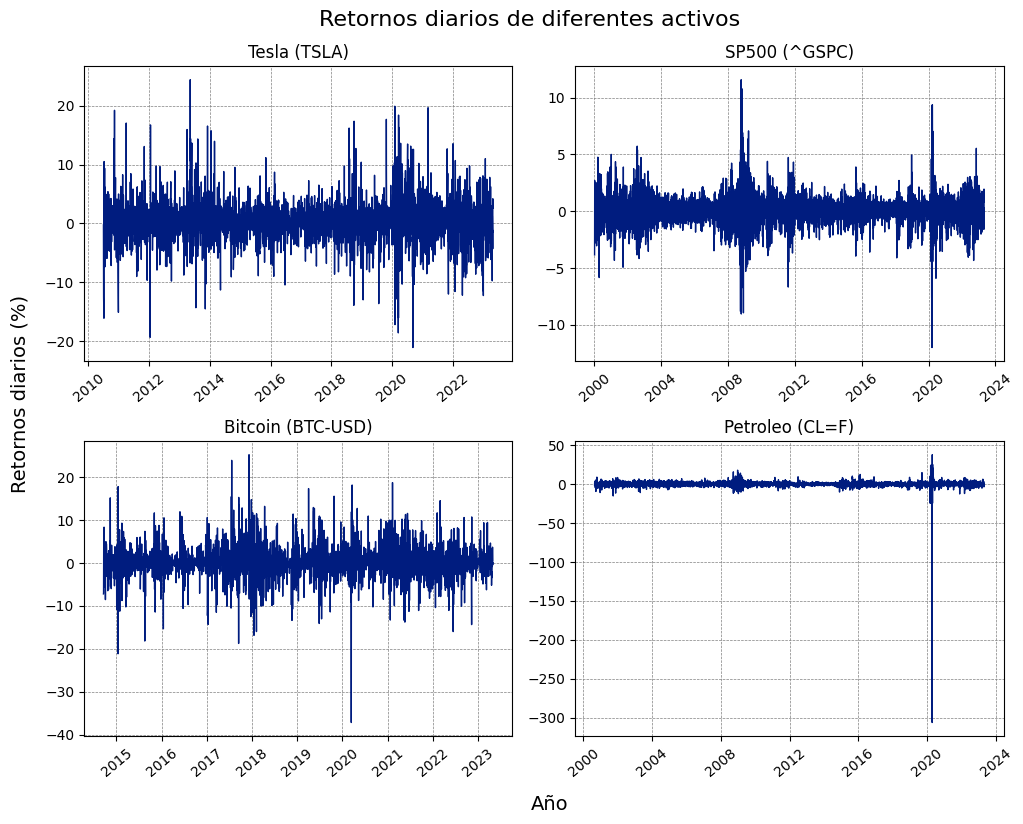

In [10]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(datos_tesla['Adj Close'].pct_change()*100, linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(datos_sp500['Adj Close'].pct_change()*100, linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(datos_bitcoin['Adj Close'].pct_change()*100, linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(datos_petroleo['Adj Close'].pct_change()*100, linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Retornos diarios (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Retornos diarios de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()


### Volatilidad en ventanas de 15 dias

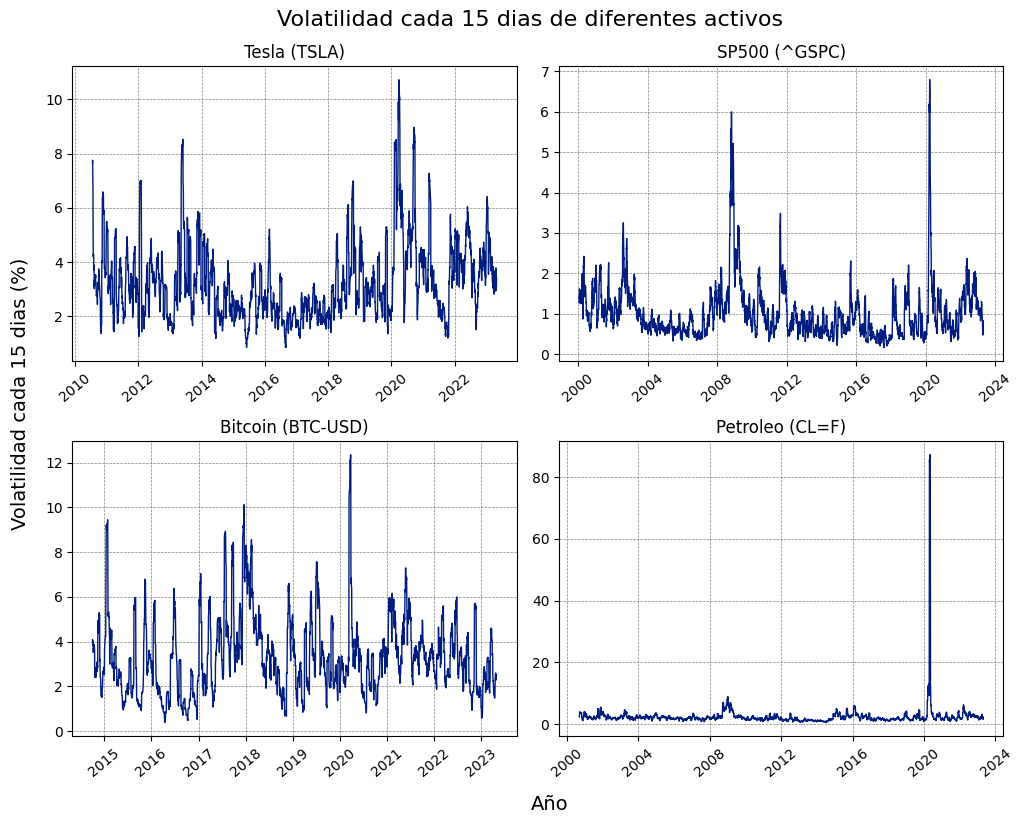

In [11]:
sns.set_palette('dark')

# Calcular la volatilidad diaria en ventanas de tiempo
window = 15
volatility_tesla = datos_tesla['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_sp500 = datos_sp500['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_bitcoin = datos_bitcoin['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_petroleo = datos_petroleo['Adj Close'].pct_change().rolling(window=window).std() * 100

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(volatility_tesla, linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(volatility_sp500, linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(volatility_bitcoin, linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(volatility_petroleo, linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)
fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Volatilidad cada 15 dias (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Volatilidad cada 15 dias de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()

### Máximo Drawdown en 15 dias

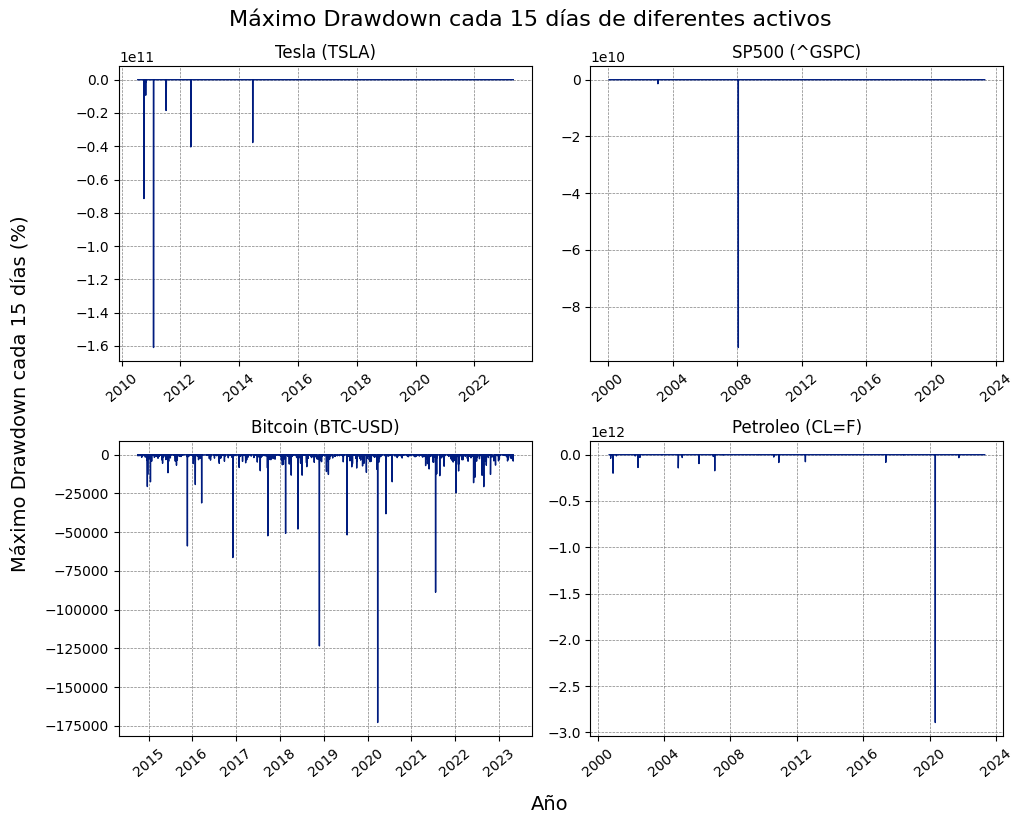

In [12]:
def max_drawdown(data):
    """
    Función para calcular el Máximo Drawdown de un conjunto de datos.
    """
    cum_returns = np.cumprod(1 + data) - 1
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / (peak + 1e-10)
    max_drawdown = drawdown.min()
    return max_drawdown

# Calcular el Máximo Drawdown en ventanas de tiempo de 15 días
window = 15
max_drawdown_tesla = datos_tesla['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_sp500 = datos_sp500['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_bitcoin = datos_bitcoin['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_petroleo = datos_petroleo['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(max_drawdown_tesla, linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(max_drawdown_sp500, linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(max_drawdown_bitcoin, linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(max_drawdown_petroleo, linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)
fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Máximo Drawdown cada 15 días (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Máximo Drawdown cada 15 días de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()

### Mapa de calor

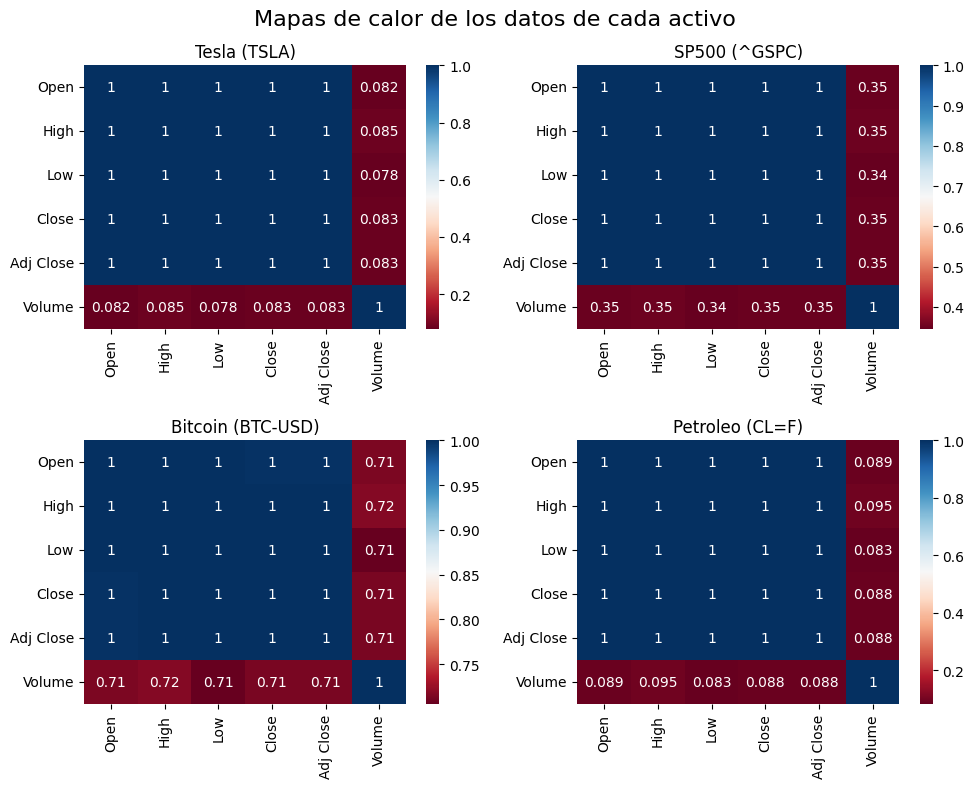

In [13]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.heatmap(datos_tesla.corr(), annot=True, cmap="RdBu", ax=axs[0, 0])
axs[0, 0].set_title('Tesla (TSLA)')
sns.heatmap(datos_sp500.corr(), annot=True, cmap="RdBu", ax=axs[0, 1])
axs[0, 1].set_title('SP500 (^GSPC)')
sns.heatmap(datos_bitcoin.corr(), annot=True, cmap="RdBu", ax=axs[1, 0])
axs[1, 0].set_title('Bitcoin (BTC-USD)')
sns.heatmap(datos_petroleo.corr(), annot=True, cmap="RdBu", ax=axs[1, 1])
axs[1, 1].set_title('Petroleo (CL=F)')

fig.suptitle('Mapas de calor de los datos de cada activo', fontsize=16)

plt.tight_layout()
plt.show()

# Preparación de los datos

Definimos las fechas de inicio y fin de train y test

In [14]:
fecha_inicio_train = '2010-01-01'
fecha_fin_train = '2019-01-01'
fecha_inicio_test = '2019-01-02'
fecha_fin_test = '2019-04-01'

Obtenemos los datos de train

In [15]:
datos_tesla = yf.download('TSLA', start=fecha_inicio_train, end=fecha_fin_train)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio_train, end=fecha_fin_train)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio_train, end=fecha_fin_train)
datos_petroleo = yf.download('CL=F', start=fecha_inicio_train, end=fecha_fin_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Creamos un dataframe nuevo con solo el precio de cierre.

In [16]:
datos_tesla = datos_tesla.loc[:,'Adj Close'].copy() 
datos_sp500 = datos_sp500.loc[:,'Adj Close'].copy()
datos_bitcoin = datos_bitcoin.loc[:,'Adj Close'].copy()
datos_petroleo = datos_petroleo.loc[:,'Adj Close'].copy()

Normalizamos / escalamos las variables para que tomen valor entre 0 y 1

In [17]:
scaler =  MinMaxScaler(feature_range=(0,1))

datos_tesla = scaler.fit_transform(np.array(datos_tesla).reshape(-1,1))
datos_sp500 = scaler.fit_transform(np.array(datos_sp500).reshape(-1,1))
datos_bitcoin = scaler.fit_transform(np.array(datos_bitcoin).reshape(-1,1))
datos_petroleo = scaler.fit_transform(np.array(datos_petroleo).reshape(-1,1))

print(datos_tesla.shape,
      datos_sp500.shape,
      datos_bitcoin.shape,
      datos_petroleo.shape)

(2142, 1) (2264, 1) (1567, 1) (2262, 1)


Definimos una función para crear datos de train y test

In [18]:
def create_time_series_dataset(data, time_steps):
    """
    Crea un conjunto de datos de series temporales para el entrenamiento de modelos de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene dos arreglos numpy. El primer arreglo contiene las etiquetas de salida (y) y el segundo arreglo contiene las ventanas de tiempo de entrada (X).
    """

    X = []
    y = []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])    # Se crea una ventana de tiempo de longitud time_steps en la serie temporal de entrada
        y.append(data[i+time_steps])      # Se obtiene la etiqueta de salida correspondiente a la ventana de tiempo
    return np.array(y), np.array(X)      # Se devuelven las etiquetas de salida y las ventanas de tiempo de entrada como arreglos numpy en una tupla



Creamos los dataset, los dividimos en train y test luego los escalamos:

In [19]:
def preparar_datos_entrenamiento(datos, pasos):
    """
    Prepara los datos de entrenamiento para modelos de series temporales.

    Parámetros:
        - datos (array-like): Serie temporal de entrada.
        - pasos (int): Número de pasos de tiempo en cada ventana de tiempo.

    Retorna:
        tuple: Una tupla que contiene cuatro arreglos numpy. Los primeros dos arreglos contienen las etiquetas de salida (y) y las ventanas de tiempo de entrada (X) respectivamente. Los otros dos arreglos contienen las ventanas de tiempo de entrada remodeladas (X_reg) para su uso en modelos que requieren datos en 2D.
    """

    y, X = create_time_series_dataset(datos, pasos)                    # Se crea el conjunto de datos de series temporales
    indices_barajados = np.random.permutation(len(y))                  # Se barajan los índices de las muestras
    X_train, y_train = X[indices_barajados], y[indices_barajados]      # Se obtienen las ventanas de tiempo y etiquetas de salida barajadas

    X_train_reg = X_train.reshape(X_train.shape[0], -1)                # Se remodelan las ventanas de tiempo para su uso en modelos que requieren datos en 2D

    return X_train, y_train, X_train_reg, y_train

Descagramos datos nuevos (test) para gráficar y hacer pruebas.

In [20]:
datos_tesla_test = yf.download('TSLA', start=fecha_inicio_test, end=fecha_fin_test)
datos_sp500_test = yf.download('^GSPC', start=fecha_inicio_test, end=fecha_fin_test)
datos_bitcoin_test = yf.download('BTC-USD', start=fecha_inicio_test, end=fecha_fin_test)
datos_petroleo_test = yf.download('CL=F', start=fecha_inicio_test, end=fecha_fin_test)

datos_tesla_test = datos_tesla_test.loc[:,'Adj Close'].copy() # todo ajustado
datos_sp500_test = datos_sp500_test.loc[:,'Adj Close'].copy()
datos_bitcoin_test = datos_bitcoin_test.loc[:,'Adj Close'].copy()
datos_petroleo_test = datos_petroleo_test.loc[:,'Adj Close'].copy()

datos_tesla_test = scaler.transform(np.array(datos_tesla_test).reshape(-1,1))
datos_sp500_test = scaler.transform(np.array(datos_sp500_test).reshape(-1,1))
datos_bitcoin_test = scaler.transform(np.array(datos_bitcoin_test).reshape(-1,1))
datos_petroleo_test = scaler.transform(np.array(datos_petroleo_test).reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Modelos de aprendizaje automático

Usaremos las sigueintes métricas para evaluar los modelos:
   * RMSE (raíz del error cuadrático medio): esta métrica es útil para evaluar la precisión de la predicción del modelo en la misma escala que los valores de la variable objetivo.

   * MSE (error cuadrático medio): al igual que el RMSE, el MSE mide la precisión de la predicción del modelo. Sin embargo, como los errores están al cuadrado, el MSE puede dar más peso a los errores grandes.

   * MAE (error absoluto medio): esta métrica es una buena opción para evaluar la precisión de la predicción en una escala fácil de interpretar. El MAE es la media de las diferencias absolutas entre las predicciones y los valores reales.

   * R2 SCORE (coeficiente de determinación): esta métrica mide la proporción de la varianza en los valores de la variable objetivo que se explica por el modelo. Es una medida útil para evaluar el ajuste del modelo en general.


### Evaluación de los modelos

In [21]:
def evaluate_model(y_pred, y_test, name, ax):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

### Funciones para las predicciones continuas

In [22]:
def evaluate_model_seguidos(y_pred, y_test, name, ax):
    """
    Evalúa y visualiza el rendimiento de un modelo de predicción en series temporales para predicciones continuas.

    Parámetros:
        - y_pred (array-like): Predicciones del modelo.
        - y_test (array-like): Valores verdaderos de la serie temporal.
        - name (str): Nombre del modelo para mostrar en la salida y en la gráfica.
        - ax (matplotlib Axes): Ejes de la gráfica en la que se mostrarán los resultados.
        - dias (int): Número de días a mostrar en la gráfica.

    Retorna:
        None
    """
    
    # Transformar las predicciones y los valores verdaderos a su escala original
    original_y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    original_y_test = scaler.inverse_transform(y_test.reshape(-1,1))

    # Calcular métricas de evaluación del modelo
    rmse = np.sqrt(mean_squared_error(original_y_pred, original_y_test))
    mse = mean_squared_error(original_y_pred, original_y_test)
    mae = mean_absolute_error(original_y_pred, original_y_test)
    r2 = r2_score(original_y_pred, original_y_test)

    # Mostrar las métricas de evaluación en la salida
    print(name)
    print("RMSE: ", rmse)
    print("MSE: ", mse)
    print("MAE: ", mae)
    print("R²: ", r2)
    print('\n')
    
    # Graficar las predicciones y los valores verdaderos en la gráfica
    ax.plot(original_y_pred[1:31], label=name, color='red')
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.plot(original_y_test[0:30], label=name, color='blue')
    ax.set_title(name)

In [23]:
def predict_n_days(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando un modelo de aprendizaje supervisado.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        aux = X.reshape(-1, 1).T           # Se ajusta la forma de las características de entrada según el modelo
        y_pred = model.predict(aux)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

In [24]:
def predict_n_days_red(data, time_steps, dias, model):
    """
    Realiza predicciones para un número específico de días en una serie temporal utilizando redes neuronales.

    Parámetros:
        - data (array-like): Serie temporal de entrada.
        - time_steps (int): Número de pasos de tiempo en cada ventana de tiempo.
        - dias (int): Número de días para los que se realizarán predicciones.
        - model (objeto modelo): Modelo de aprendizaje supervisado previamente entrenado.

    Retorna:
        array: Arreglo numpy que contiene las predicciones para los días especificados.
    """

    y = []
    for i in range(dias):
        X = data[i:i+time_steps]            # Se extrae la ventana de tiempo de la serie temporal
        X = X.reshape(X.shape[1], X.shape[0] , 1)
        y_pred = model.predict(X, verbose=False)        # Se realiza la predicción utilizando el modelo
        data = np.append(data, y_pred)      # Se agrega la predicción al final de la serie temporal
        data = data.reshape(-1, 1)

        y.append(y_pred)                   # Se agrega la predicción al arreglo de predicciones
        
    return np.array(y)                     # Se devuelve el arreglo de predicciones como un arreglo numpy

## Regresión Lineal

### Preparación de datos

In [25]:
pasos = 5  # Número de pasos de tiempo en cada ventana
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)

### Entrenamiento

In [26]:
model_lr_tesla = LinearRegression()
model_lr_tesla.fit(x_train_tesla_reg, y_train_tesla)

model_lr_sp500 = LinearRegression()
model_lr_sp500.fit(x_train_sp500_reg, y_train_sp500)

model_lr_bitcoin = LinearRegression()
model_lr_bitcoin.fit(x_train_bitcoin_reg, y_train_bitcoin)

model_lr_petroleo = LinearRegression()
model_lr_petroleo.fit(x_train_petroleo_reg, y_train_petroleo)


LinearRegression()

### Comparación entre el precio predicho y el precio de cierre ajustado real (día siguiente)

Tesla (TSLA)
RMSE:  0.6480747940784695
MSE:  0.42000093871985067
MAE:  0.426894946444531
R²:  0.8160231491061393


SP500 (^GSPC)
RMSE:  19.421183902575244
MSE:  377.18238417764775
MAE:  15.061455007235606
R²:  0.9381567058725674


Bitcoin (BTC-USD)
RMSE:  82.91505945704448
MSE:  6874.907084765222
MAE:  50.709813657165604
R²:  0.8418605702291069


Petroleo (CL=F)
RMSE:  0.9161606273301245
MSE:  0.8393502950699272
MAE:  0.7287168209643482
R²:  0.88174110208953




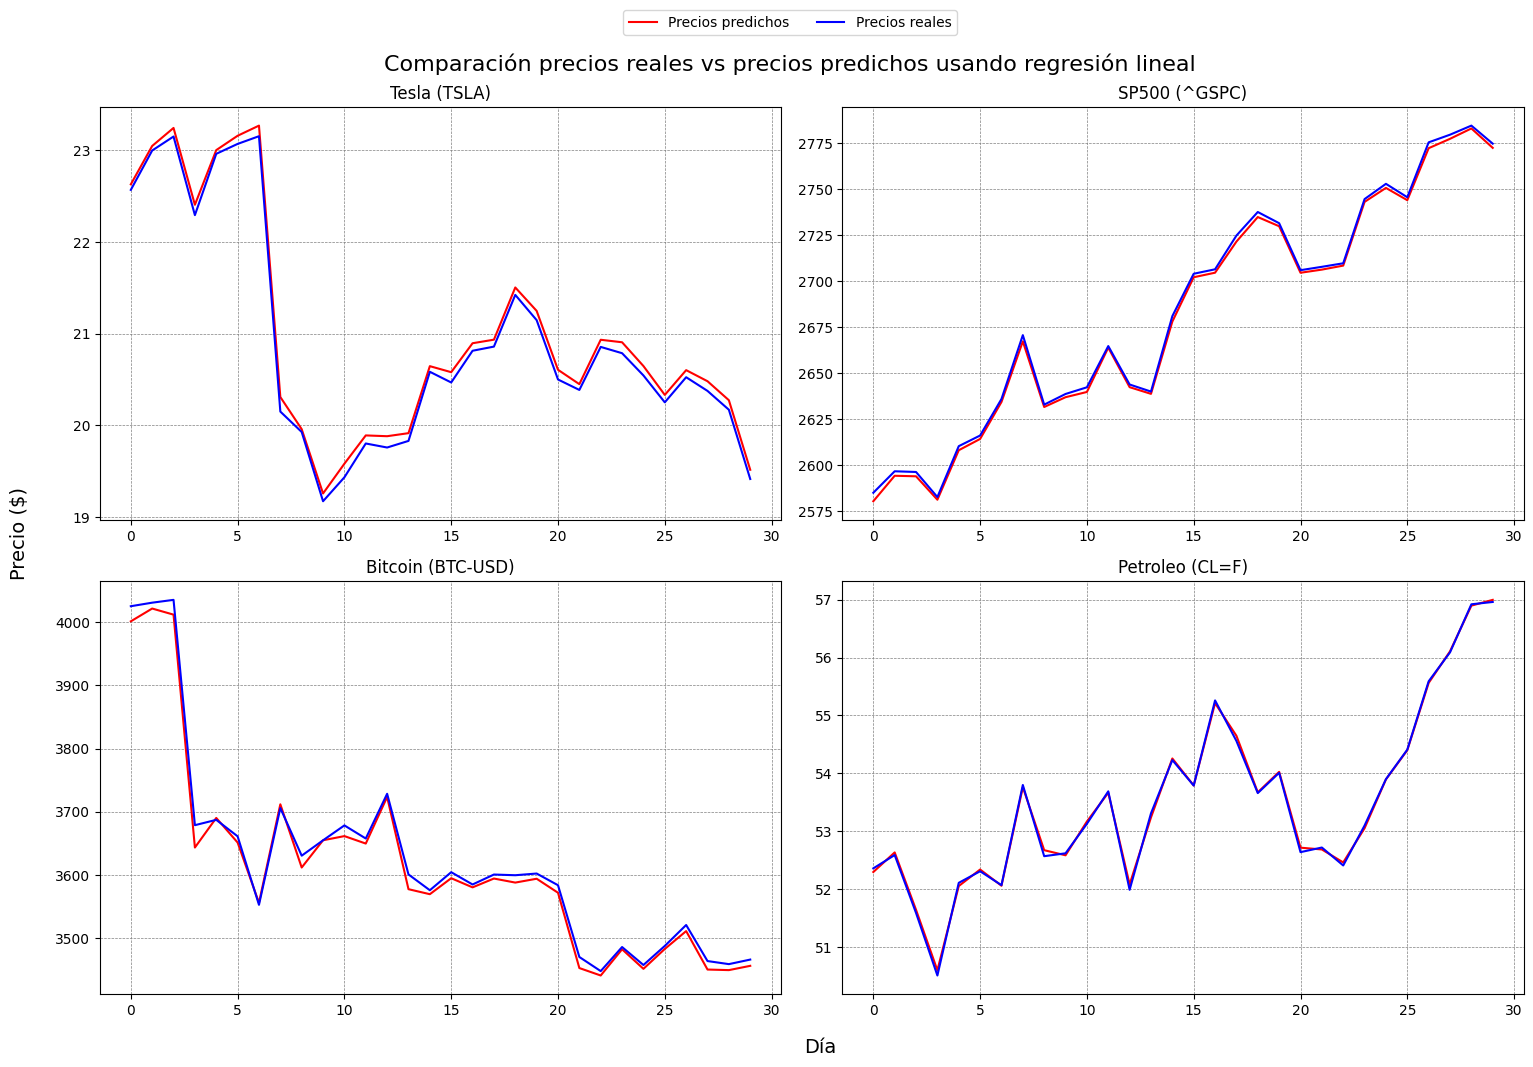

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_lr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0])

y_pred_sp500_t = model_lr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1])

y_pred_bitcoin_t = model_lr_bitcoin.predict(x_bitcoin_t_reg) 
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0])

y_pred_petroleo_t = model_lr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1])

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  2.5907207083995574
MSE:  6.711833788930305
MAE:  2.008321160519835
R²:  -50.12913566142491


SP500 (^GSPC)
RMSE:  76.69130763614537
MSE:  5881.5566669418895
MAE:  68.2194333102274
R²:  -149.946683998296


Bitcoin (BTC-USD)
RMSE:  295.4370275846117
MSE:  87283.03726803062
MAE:  268.63410491515623
R²:  -33.282317644583955


Petroleo (CL=F)
RMSE:  2.804809789305288
MSE:  7.866957954182774
MAE:  2.668054304881382
R²:  -1031.6101641657147




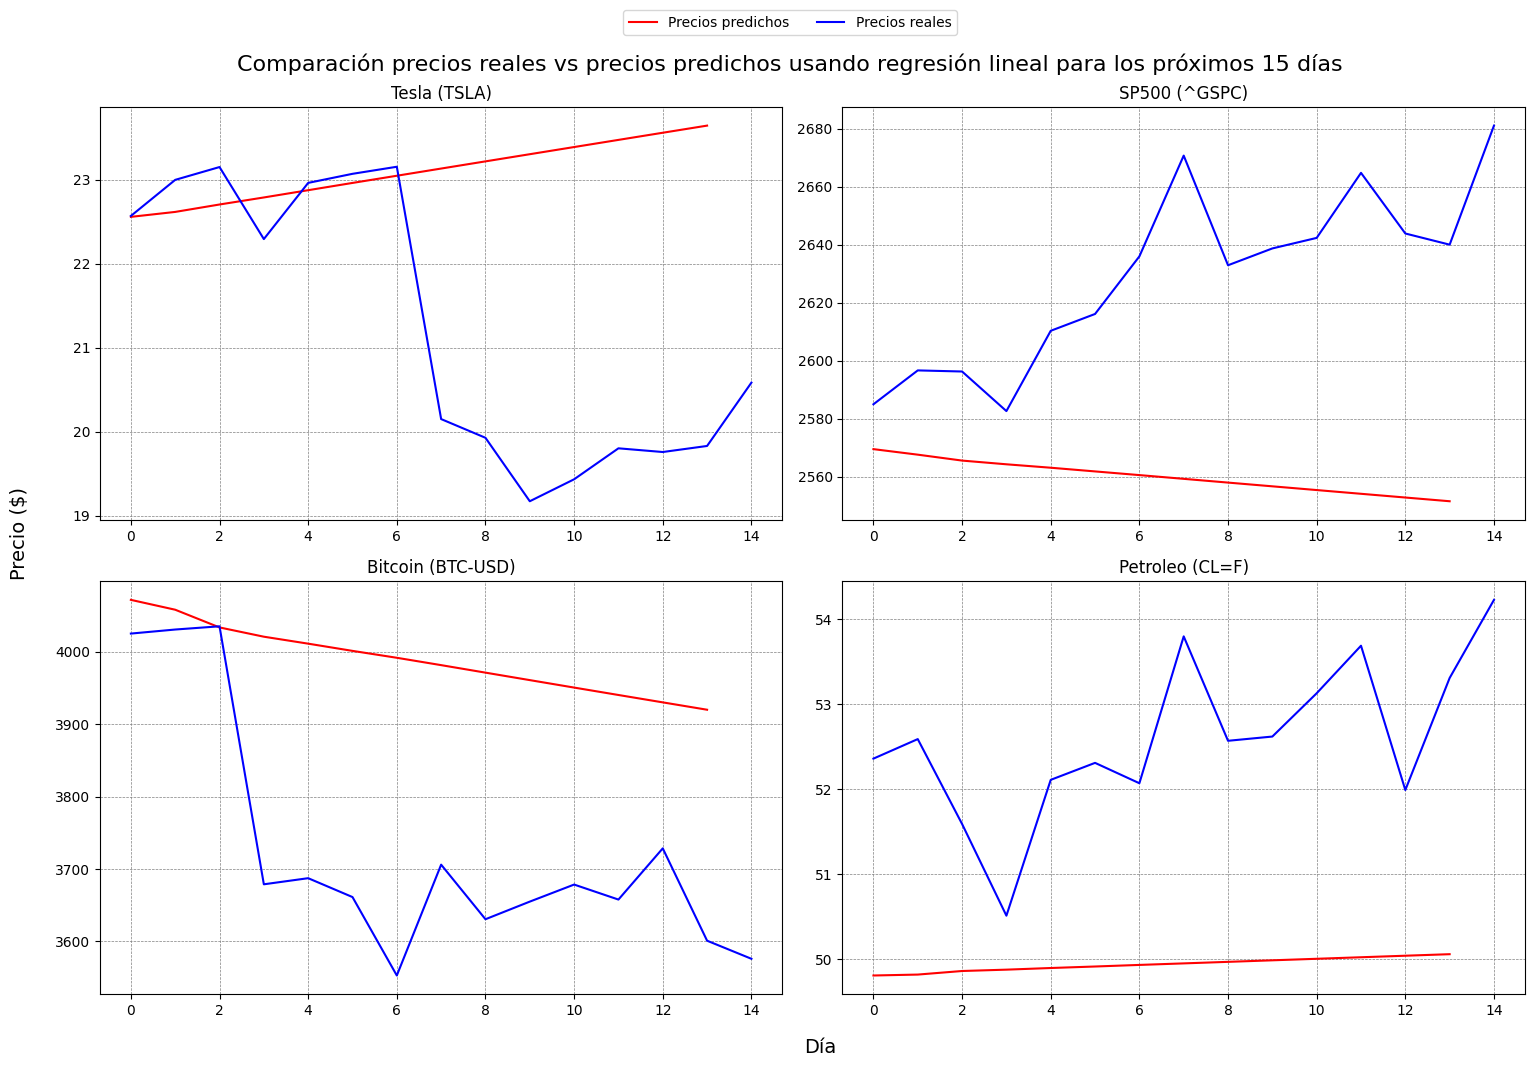

In [28]:
ventana = pasos
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:ventana], ventana, dias, model_lr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0])

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:ventana], ventana, dias, model_lr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1])

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:ventana], ventana, dias, model_lr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0])

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:ventana], ventana, dias, model_lr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1])

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

## SVR

Volvemos a preparar los datos ya que este modelo empelará una ventana diferente:

In [29]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 10
pasos_sp500 = 20
pasos_bitcoin = 30
pasos_petroleo = 23

y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento para Tesla
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)

# Preparar datos de entrenamiento para S&P 500
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)

# Preparar datos de entrenamiento para bitcoin
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)

# Preparar datos de entrenamiento para petróleo
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
x_tesla_t_reg = x_tesla_t.reshape(x_tesla_t.shape[0], -1)

y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
x_sp500_t_reg = x_sp500_t.reshape(x_sp500_t.shape[0], -1)

y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
x_bitcoin_t_reg = x_bitcoin_t.reshape(x_bitcoin_t.shape[0], -1)

y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)
x_petroleo_t_reg = x_petroleo_t.reshape(x_petroleo_t.shape[0], -1)


In [30]:
model_svr_tesla = SVR()
param_grid = {'C': [20000, 40000, 50000, 60000], 'gamma': [0.0001, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000018, 0.000019], 'kernel': ['rbf']}
grid_search = GridSearchCV(model_svr_tesla, param_grid, cv=5, scoring='r2')
grid_search.fit(x_train_tesla_reg, np.ravel(y_train_tesla))
model_svr_tesla = grid_search.best_estimator_
best_params_tesla_svr = grid_search.best_params_

model_svr_sp500 = SVR()
param_grid = {'C': [0.1, 0.5, 1, 10, 100, 200, 500, 1000], 'gamma': [1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.90, 0.95, 10], 'kernel': ['linear']}
grid_search = GridSearchCV(model_svr_sp500, param_grid, cv=5, scoring='r2')
grid_search.fit(x_train_sp500_reg, np.ravel(y_train_sp500))
model_svr_sp500 = grid_search.best_estimator_
best_params_sp500_svr = grid_search.best_params_

model_svr_bitcoin = SVR()
param_grid = {'C': [0.0000001, 0.1, 0.5, 1, 10, 100, 500, 1000, 1100, 1200, 1300, 1400, 1500], 'gamma': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.90, 0.95, 10, 11, 12, 20], 'kernel': ['linear']}
grid_search = GridSearchCV(model_svr_bitcoin, param_grid, cv=5, scoring='r2')
grid_search.fit(x_train_bitcoin_reg, np.ravel(y_train_bitcoin))
model_svr_bitcoin = grid_search.best_estimator_
best_params_btc_svr = grid_search.best_params_

model_svr_petroleo = SVR()
param_grid = {'C': [3500, 4000, 4500, 10000, 20000, 30000, 40000, 50000, 60000, 61000], 'gamma': [0.0001, 0.000012, 0.000013, 0.000014, 0.000015, 0.000016, 0.000017, 0.000018, 0.000019], 'kernel': ['rbf']}
grid_search = GridSearchCV(model_svr_petroleo, param_grid, cv=5, scoring='r2')
grid_search.fit(x_train_petroleo_reg, np.ravel(y_train_petroleo))
model_svr_petroleo = grid_search.best_estimator_
best_params_petroleo_svr = grid_search.best_params_

In [31]:
best_params_petroleo_svr

{'C': 61000, 'gamma': 1.3e-05, 'kernel': 'rbf'}

Tesla (TSLA)
RMSE:  3.963228781826437
MSE:  15.707182377097462
MAE:  3.8968105382599467
R²:  -11.280447269015482


SP500 (^GSPC)
RMSE:  236.40310113253076
MSE:  55886.426225077565
MAE:  234.7781824338482
R²:  -18.308619440559653


Bitcoin (BTC-USD)
RMSE:  616.2658633319753
MSE:  379783.61430830485
MAE:  610.1990555454703
R²:  -10.418927100245273


Petroleo (CL=F)
RMSE:  0.8465845945417105
MSE:  0.7167054757153525
MAE:  0.7088289897096832
R²:  0.7744110909931936




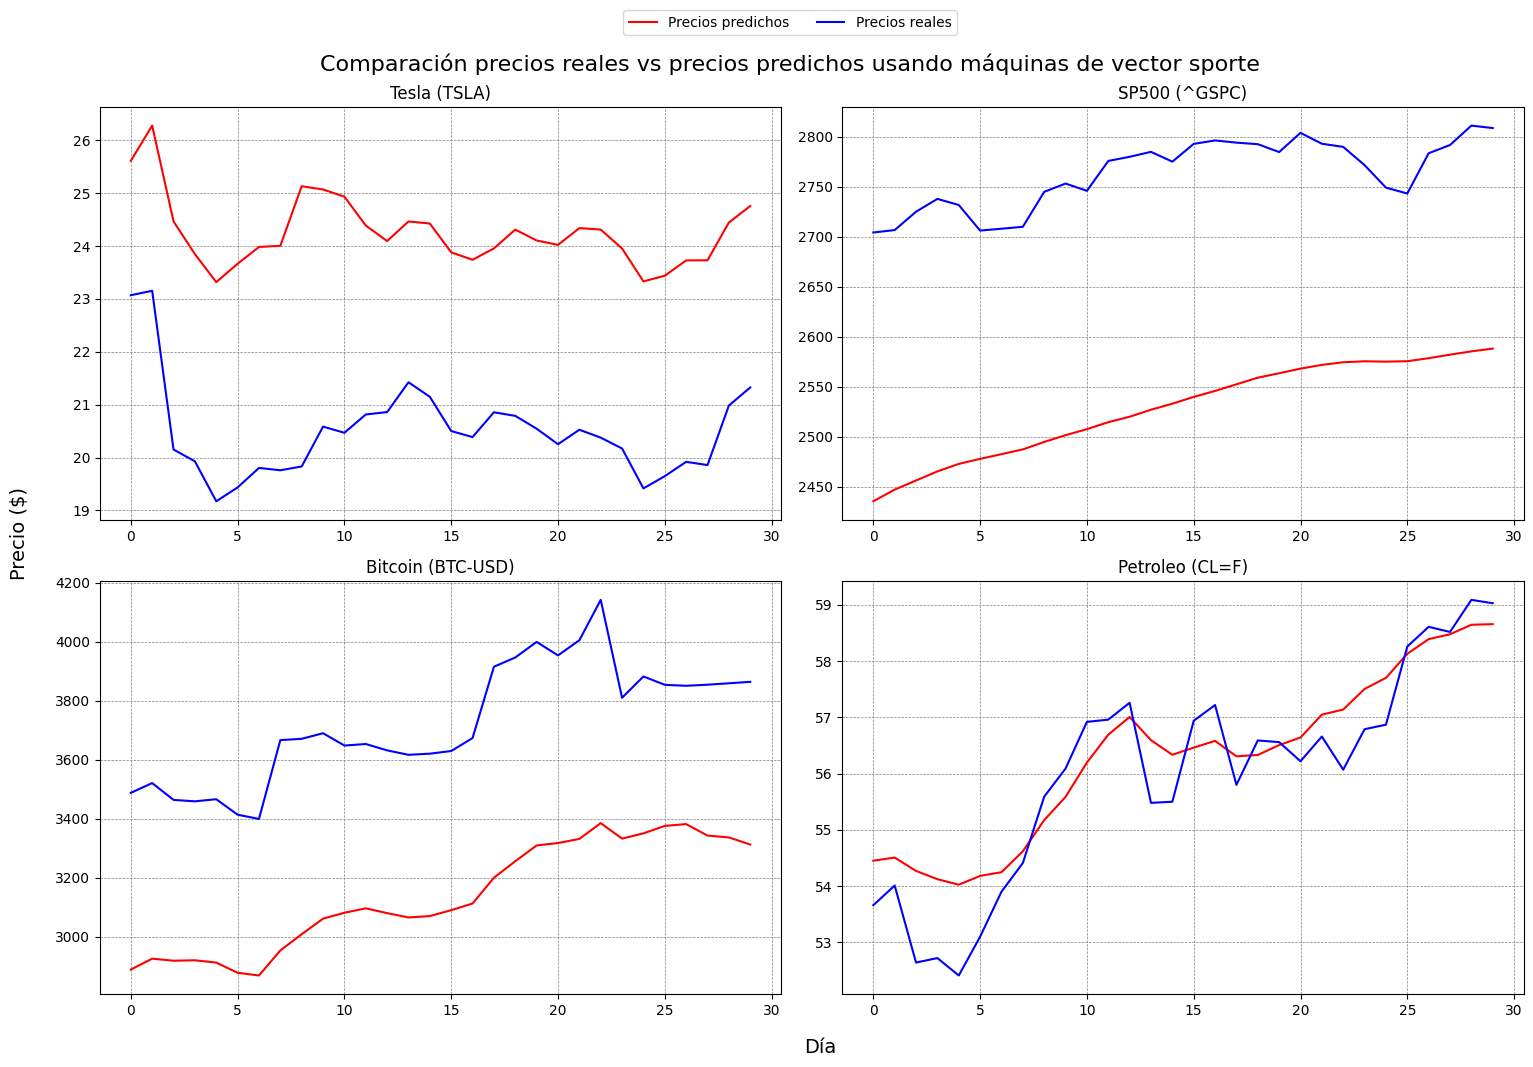

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = model_svr_tesla.predict(x_tesla_t_reg)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0])

y_pred_sp500_t = model_svr_sp500.predict(x_sp500_t_reg)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1])

y_pred_bitcoin_t = model_svr_bitcoin.predict(x_bitcoin_t_reg)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0])

y_pred_petroleo_t = model_svr_petroleo.predict(x_petroleo_t_reg)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1])

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando máquinas de vector sporte', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

    El modelo es demasiado simple o no es adecuado para los datos, lo que significa que no es capaz de capturar la complejidad de la relación entre las variables predictoras y la variable objetivo.

    Las características (variables predictoras) que se están utilizando no son relevantes para predecir la variable objetivo.

    La variable objetivo tiene demasiado ruido o variabilidad, lo que hace que sea difícil de predecir.

    El modelo se ha sobreajustado a los datos de entrenamiento y no generaliza bien a nuevos datos.

### Predicción de los siguientes 15 días

Tesla (TSLA)
RMSE:  13.147669448677487
MSE:  172.86121193168736
MAE:  12.47477006654728
R²:  -12.953731528561024


SP500 (^GSPC)
RMSE:  394.18314640217966
MSE:  155380.3529075222
MAE:  386.3020418220829
R²:  -55.27919656328522


Bitcoin (BTC-USD)
RMSE:  2063.009515120628
MSE:  4256008.259478249
MAE:  1894.8061298770217
R²:  -6.7199221726822636


Petroleo (CL=F)
RMSE:  1.6293955119805938
MSE:  2.6549297344625016
MAE:  1.388012476947638
R²:  -4.536520057393539




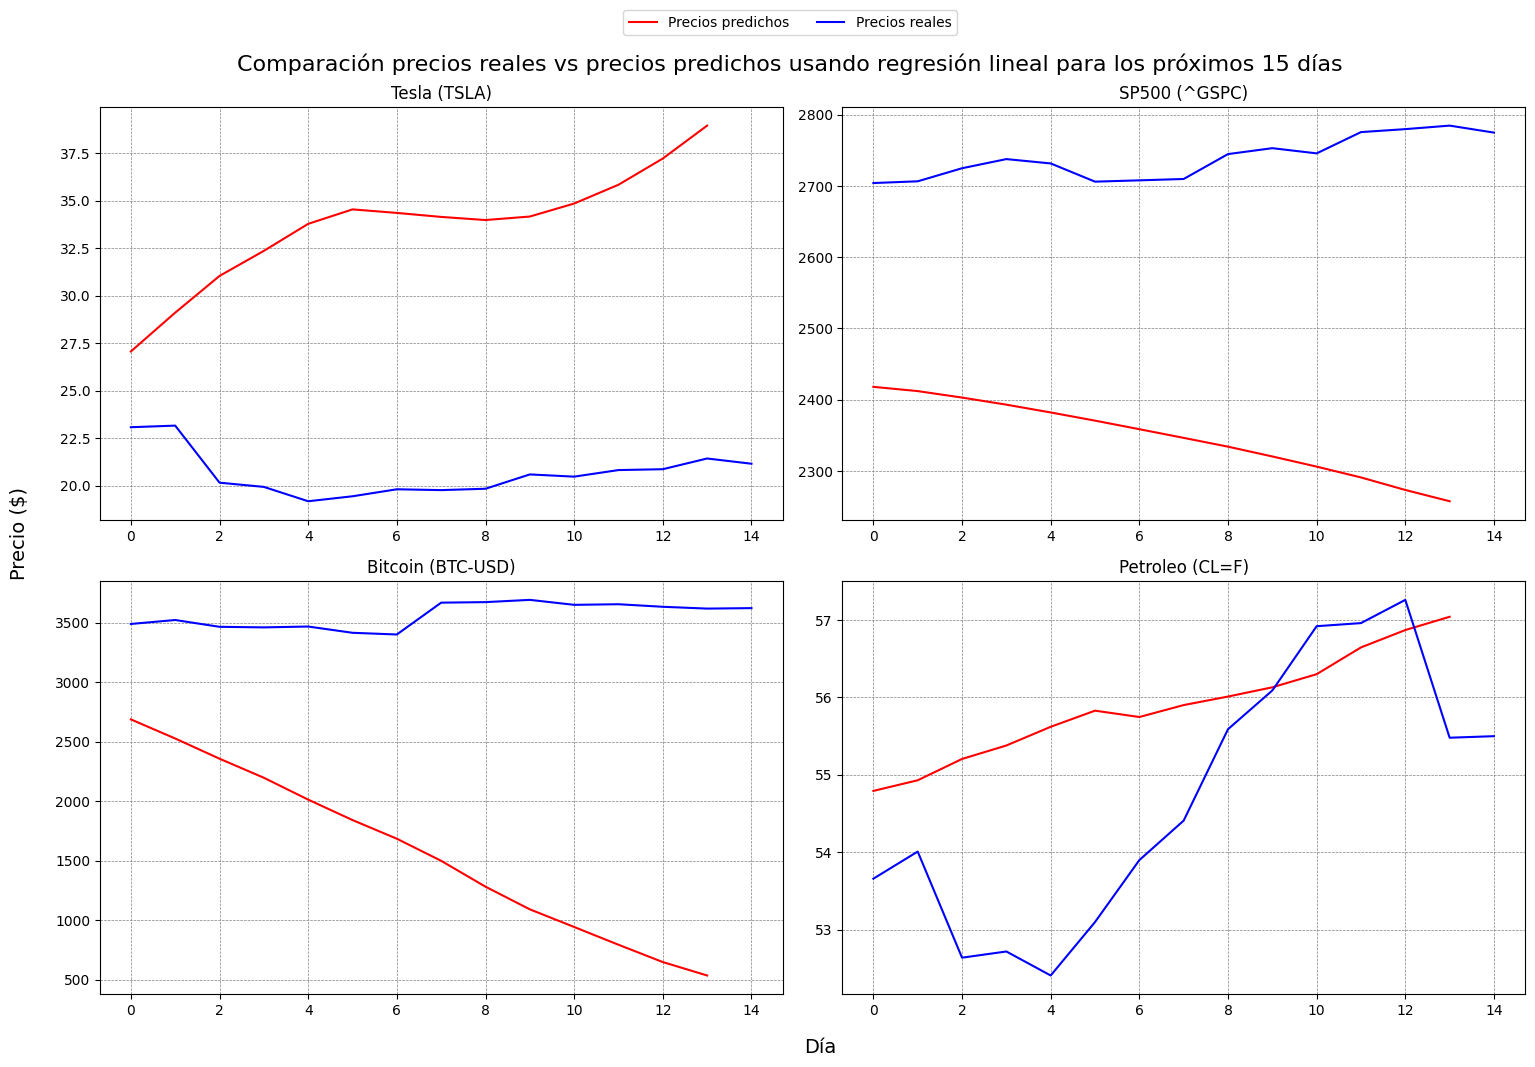

In [33]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, model_svr_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0])

y_pred_sp500_t = predict_n_days(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, model_svr_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1])

y_pred_bitcoin_t = predict_n_days(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, model_svr_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0])

y_pred_petroleo_t = predict_n_days(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, model_svr_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1])

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

# LSTM

Preparamos los datos de entrenamiento

In [39]:
# Número de pasos de tiempo en cada ventana
pasos_tesla = 60
pasos_sp500 = 30
pasos_bitcoin = 25
pasos_petroleo = 5

# Creamos los dataframes
y_tesla, x_tesla = create_time_series_dataset(datos_tesla, pasos_tesla)
y_sp500, x_sp500 = create_time_series_dataset(datos_sp500, pasos_sp500)
y_bitcoin, x_bitcoin = create_time_series_dataset(datos_bitcoin, pasos_bitcoin)
y_petroleo, x_petroleo = create_time_series_dataset(datos_petroleo, pasos_petroleo)

# Preparar datos de entrenamiento 
x_train_tesla, y_train_tesla, x_train_tesla_reg, y_train_tesla_reg = preparar_datos_entrenamiento(datos_tesla, pasos_tesla)
x_train_sp500, y_train_sp500, x_train_sp500_reg, y_train_sp500_reg = preparar_datos_entrenamiento(datos_sp500, pasos_sp500)
x_train_bitcoin, y_train_bitcoin, x_train_bitcoin_reg, y_train_bitcoin_reg = preparar_datos_entrenamiento(datos_bitcoin, pasos_bitcoin)
x_train_petroleo, y_train_petroleo, x_train_petroleo_reg, y_train_petroleo_reg = preparar_datos_entrenamiento(datos_petroleo, pasos_petroleo)

# Preparar datos de Test
y_tesla_t, x_tesla_t = create_time_series_dataset(datos_tesla_test, pasos_tesla)
y_sp500_t, x_sp500_t = create_time_series_dataset(datos_sp500_test, pasos_sp500)
y_bitcoin_t, x_bitcoin_t = create_time_series_dataset(datos_bitcoin_test, pasos_bitcoin)
y_petroleo_t, x_petroleo_t = create_time_series_dataset(datos_petroleo_test, pasos_petroleo)


In [40]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

lstm_tesla = Sequential()
lstm_tesla.add(LSTM(units=50, input_shape=(pasos_tesla, 1), activation="relu"))
lstm_tesla.add(Dense(1)) 
lstm_tesla.compile(optimizer='adam', loss='mse')
history = lstm_tesla.fit(x_train_tesla, y_train_tesla, epochs=50, batch_size=32, validation_data=(x_tesla_t, y_tesla_t), verbose = False)
score = lstm_tesla.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_tesla_t = lstm_tesla.predict(x_tesla_t)
evaluate_model(y_pred_tesla_t, y_tesla_t, "Tesla (TSLA)", axs[0, 0])


lstm_sp500 = Sequential()
lstm_sp500.add(LSTM(units=50, input_shape=(pasos_sp500, 1), activation="relu"))
lstm_sp500.add(Dense(1)) 
lstm_sp500.compile(optimizer='adam', loss='mse')
history = lstm_sp500.fit(x_train_sp500, y_train_sp500, epochs=50, batch_size=32, validation_data=(x_sp500_t, y_sp500_t), verbose = False)
score = lstm_sp500.evaluate(x_tesla_t, y_tesla_t, batch_size=32)
y_pred_sp500_t = lstm_sp500.predict(x_sp500_t)
evaluate_model(y_pred_sp500_t, y_sp500_t, "SP500 (^GSPC)", axs[0, 1])


lstm_bitcoin = Sequential()
lstm_bitcoin.add(LSTM(units=50, input_shape=(pasos_bitcoin, 1), activation="relu"))
lstm_bitcoin.add(Dense(1)) 
lstm_bitcoin.compile(optimizer='adam', loss='mse')
history = lstm_bitcoin.fit(x_train_bitcoin, y_train_bitcoin, epochs=50, batch_size=32, validation_data=(x_bitcoin_t, y_bitcoin_t), verbose = False)
score = lstm_bitcoin.evaluate(x_bitcoin_t, y_bitcoin_t, batch_size=32)
y_pred_bitcoin_t = lstm_bitcoin.predict(x_bitcoin_t)
evaluate_model(y_pred_bitcoin_t, y_bitcoin_t, "Bitcoin (BTC-USD)", axs[1, 0])


lstm_petroleo = Sequential()
lstm_petroleo.add(LSTM(units=10, input_shape=(pasos_petroleo, 1), activation="relu"))
lstm_petroleo.add(Dense(1)) 
lstm_petroleo.compile(optimizer='adam', loss='mse')
history = lstm_petroleo.fit(x_train_petroleo, y_train_petroleo, epochs=50, batch_size=32, validation_data=(x_petroleo_t, y_petroleo_t), verbose = False)
score = lstm_petroleo.evaluate(x_petroleo_t, y_petroleo_t, batch_size=32)
y_pred_petroleo_t = lstm_petroleo.predict(x_petroleo_t)
evaluate_model(y_pred_petroleo_t, y_petroleo_t, "Petroleo (CL=F)", axs[1, 1])


fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando máquinas de vector sporte', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()

Tesla (TSLA)
RMSE:  1.4536760563105127
MSE:  2.1131740766904845
MAE:  1.2836218516031903
R²:  -1.6706030423432856


SP500 (^GSPC)
RMSE:  35630.219475007034
MSE:  1269512539.8371704
MAE:  24229.025227864582
R²:  -0.4327313383094922


Bitcoin (BTC-USD)
RMSE:  24062.3693133173
MSE:  578997616.970474
MAE:  17088.8168741862
R²:  -1.0325219784956032


Petroleo (CL=F)
RMSE:  3.1392204929671657
MSE:  9.854705303465016
MAE:  3.044001261393229
R²:  -38.461382602499796




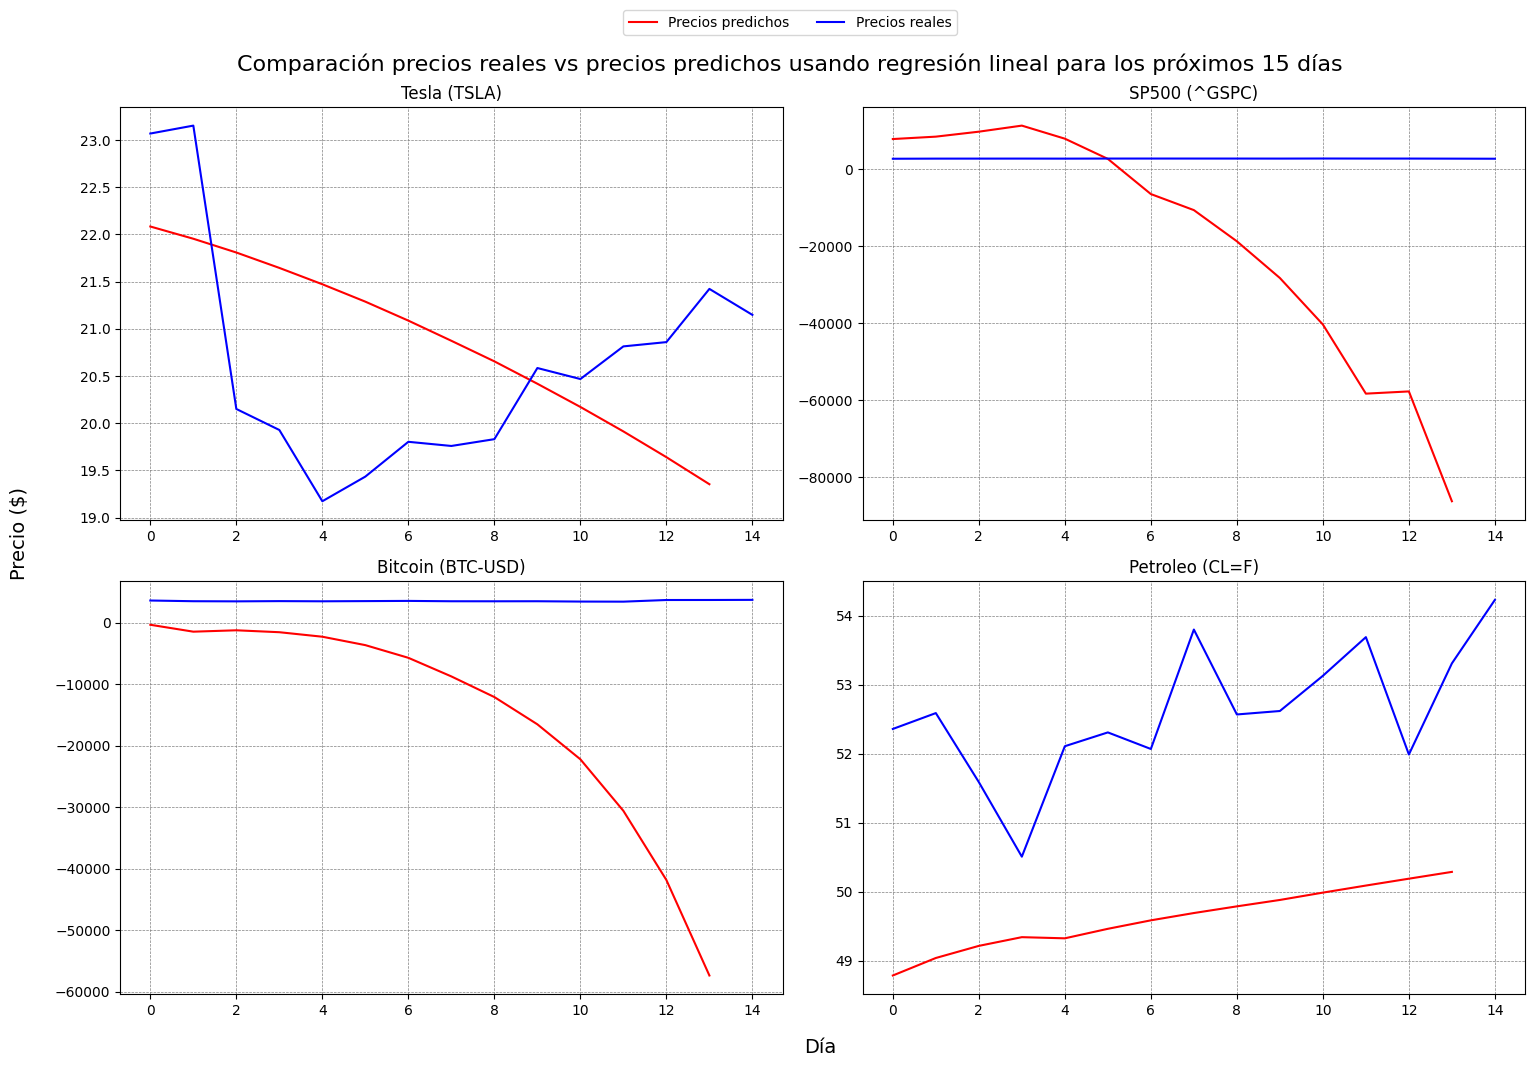

In [ ]:
dias = 15

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

y_pred_tesla_t = predict_n_days_red(datos_tesla_test[0:pasos_tesla], pasos_tesla, dias, lstm_tesla)
evaluate_model_seguidos(y_pred_tesla_t, y_tesla_t[0:dias], "Tesla (TSLA)", axs[0, 0])

y_pred_sp500_t = predict_n_days_red(datos_sp500_test[0:pasos_sp500], pasos_sp500, dias, lstm_sp500)
evaluate_model_seguidos(y_pred_sp500_t, y_sp500_t[0:dias], "SP500 (^GSPC)", axs[0, 1])

y_pred_bitcoin_t = predict_n_days_red(datos_bitcoin_test[0:pasos_bitcoin], pasos_bitcoin, dias, lstm_bitcoin)
evaluate_model_seguidos(y_pred_bitcoin_t, y_bitcoin_t[0:dias], "Bitcoin (BTC-USD)", axs[1, 0])

y_pred_petroleo_t = predict_n_days_red(datos_petroleo_test[0:pasos_petroleo], pasos_petroleo, dias, lstm_petroleo)
evaluate_model_seguidos(y_pred_petroleo_t, y_petroleo_t[0:dias], "Petroleo (CL=F)", axs[1, 1])

fig.text(0.52, -0.02, 'Día', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Comparación precios reales vs precios predichos usando regresión lineal para los próximos 15 días', fontsize=16)
fig.legend(['Precios predichos', 'Precios reales'], loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()